In [1]:
%matplotlib inline

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.autograd import Variable

from __future__ import print_function

from PIL import Image

from utils import *

import sys; sys.argv=['']; del sys

** Sepcify parameters **

In [2]:
# Training settings

parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.005, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--decay', type=float, default=0.00001, metavar='LR',
                    help='learning rate (default: 0.00001)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
help='how many batches to wait before logging training status')

args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

** Define Data Loaders **
1. Data transformations
        - Horizontal flipping

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Scale(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../Data/'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=args.batch_size,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

RuntimeError: Found 0 images in subfolders of: ../Data/train
Supported image extensions are: .jpg,.JPG,.jpeg,.JPEG,.png,.PNG,.ppm,.PPM,.bmp,.BMP

** Visualize  Patches **

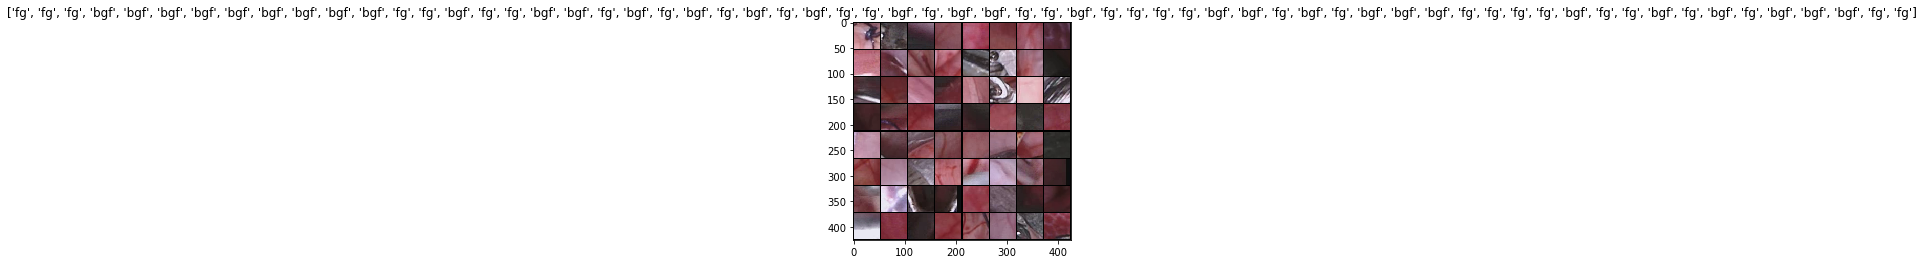

In [4]:
## Uncomment below to visualize dataset ######

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

** Define Model and Optimizer **

In [4]:
from vgg import *

model = VGG('VGG19')
arch = 'VGG19'

if args.cuda:
    model.cuda()

** Define optimizer **

In [5]:
optimizer = optim.Adadelta(model.parameters())

** Define Train and Test Functions **

In [6]:
def train(epoch):
    
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(dset_loaders['train']):
        if args.cuda:
            data, target = data.cuda(), target.cuda()        
           
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)        
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dset_loaders['train'].dataset),
                100. * batch_idx / len(dset_loaders['train']), loss.data[0]), end='\r')
            
        train_loss += loss.data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        
        
                
        
    train_loss /= len(dset_loaders['train'])
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, correct, len(dset_loaders['train'].dataset),
        100. * correct / len(dset_loaders['train'].dataset)))
    
    return train_loss, 100. * correct / len(dset_loaders['train'].dataset)
            
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in dset_loaders['val']:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        
        
                       

    test_loss = test_loss
    test_loss /= len(dset_loaders['val']) # loss function already averages over batch size
    
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dset_loaders['val'].dataset),
        100. * correct / len(dset_loaders['val'].dataset)))
    
    return test_loss, 100. * correct / len(dset_loaders['val'].dataset)

** Train **

In [7]:
performance = {}
history = {}
best_test_accuracy = 0.0
path = 'models/'

for epoch in range(1, args.epochs+1):
    
    adjust_learning_rate(optimizer,args.lr,args.decay,epoch)   
    
    train_loss,train_accuracy = train(epoch)
    test_loss, test_accuracy  = test(epoch)
    
    performance['train_loss'] = train_loss
    performance['test_loss'] = test_loss
    performance['train_acc'] = train_accuracy
    performance['test_acc'] = test_accuracy
        
    history = evaluate_model_and_append('./Train_Stats/',performance,history)
    plot_performance('./Train_Stats/',history)
    
    
#     print(optimizer.param_groups[0]['lr'])

    
    
    is_best = test_accuracy > best_test_accuracy
    
    print('test accuracy {} best {} is_best {}'.format(test_accuracy,best_test_accuracy,is_best))    
    
    prev_best  = best_test_accuracy    
    best_test_accuracy = max(best_test_accuracy, test_accuracy)
    
    print('test accuracy {} best {} is_best {}'.format(test_accuracy,best_test_accuracy,is_best))
    
    save_checkpoint({
            'epoch': epoch + 1,
            'arch': arch,
            'state_dict': model.state_dict(),
            'best_prec1': best_test_accuracy,
            'optimizer' : optimizer.state_dict(),
        }, prev_best, is_best, path)

NameError: global name 'dset_loaders' is not defined

** Load pre-trained model **

In [8]:
model_path = 'models/model_best_99.38.pkl'

print("=> loading checkpoint '{}'".format(model_path))
checkpoint = torch.load(model_path)
args.start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
model.load_state_dict(checkpoint['state_dict'])
model.eval()
optimizer.load_state_dict(checkpoint['optimizer'])
print("=> loaded checkpoint '{}' (epoch {}) (accuracy {})"
      .format(model_path, checkpoint['epoch'], checkpoint['best_prec1']))

=> loading checkpoint 'models/model_best_99.38.pkl'
=> loaded checkpoint 'models/model_best_99.38.pkl' (epoch 30) (accuracy 99.3796114274)


** Evaluate on Example image **

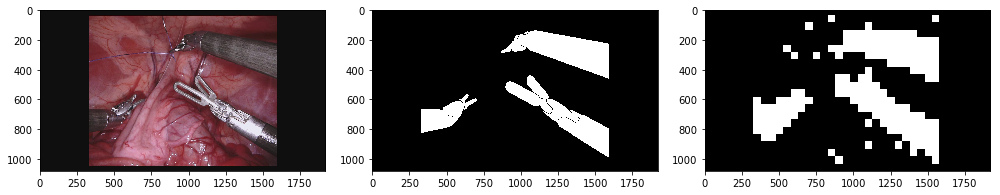

In [10]:
box_side = 50

image = np.asarray(Image.open("../Data/Test/Images/frame001.png"))
gt_mask = np.asarray(Image.open("../Data/Test/Ground_Truth/frame001.png")) 
gt_mask = (gt_mask>0)
    
    
seg_mask,seg_img = get_predict(model,image,box_side)

plt.figure(figsize=(14, 12))
plt.subplot(131)
plt.imshow(image)
plt.subplot(132)
plt.imshow(gt_mask,cmap='gray')
plt.subplot(133)
plt.imshow(seg_mask,cmap='gray')


plt.tight_layout()
plt.show()

### Evaluate output IOU

In [11]:
print('CNN output IOU {}'.format(IOU(gt_mask,seg_mask)))

CNN output IOU 0.576912358606
